In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 함수 정의 모듈 여기에 삽입

def getCloseDataPandas(ticker, start, end):
    print(ticker)
    return data.get_data_yahoo(ticker, start, end)['Close']
def getDayReturn(closeDataSet):
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)
def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]
def getPortfolioResult(closeDataSet, weight=None):
# 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
# 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
# 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
# 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
# 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
    return portfolioDayReturn, portfolioCumulativeReturn
def getEvaluation(cumulativeReturn):

# cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
# mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")
    return cagr, dd, mdd

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
# 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)]*len(rebalancingDate),index=rebalancingDate,columns=closeDataSet.columns)
# 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일
    
    for end in rebalancingDate[1:]:
        weight = weightDf.loc[end] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
    return portfolioDayReturn, portfolioCumulativeReturn

In [3]:
# 종가 데이터 가져오기 함수 정의

def getCloseData(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)['Close']

In [4]:
# 데이터 로드
# 명시한 종목의 종가를 명시한 날짜부터 오늘까지의 데이터 가져오기

kodex200 = getCloseData("069500", "2021-9-1")
kodex200

Date
2021-09-01    41056
2021-09-02    40680
2021-09-03    40943
2021-09-06    41086
2021-09-07    40841
              ...  
2022-10-25    29198
2022-10-26    29397
2022-10-27    29910
2022-10-28    29525
2022-10-31    29975
Name: Close, Length: 285, dtype: int64

#### Rebalancing 날짜 계산

In [5]:
# Rebalancing 날짜 계산 함수 정의

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    print("data:", data)
    print("")
    data = pd.DataFrame(data) # 시리즈형 데이터가 들어오더라도 리밸런싱 날짜를 계산하기
    data.index = pd.to_datetime(data.index)
    print("data.index:", data.index)
    print("")
    data['year'] = data.index.year
    data['month'] = data.index.month
    # 월말 리밸런싱
    if period == "month":
        # 연, 월이 같은 날짜는 모두 제거
        # 마지막 날짜만 남겨둠
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index

    return rebalancingDate

In [6]:
# 리밸런싱 일자
rebalDate = getRebalancingDate(kodex200)
rebalDate

data: Date
2021-09-01    41056
2021-09-02    40680
2021-09-03    40943
2021-09-06    41086
2021-09-07    40841
              ...  
2022-10-25    29198
2022-10-26    29397
2022-10-27    29910
2022-10-28    29525
2022-10-31    29975
Name: Close, Length: 285, dtype: int64

data.index: DatetimeIndex(['2021-09-01', '2021-09-02', '2021-09-03', '2021-09-06',
               '2021-09-07', '2021-09-08', '2021-09-09', '2021-09-10',
               '2021-09-13', '2021-09-14',
               ...
               '2022-10-18', '2022-10-19', '2022-10-20', '2022-10-21',
               '2022-10-24', '2022-10-25', '2022-10-26', '2022-10-27',
               '2022-10-28', '2022-10-31'],
              dtype='datetime64[ns]', name='Date', length=285, freq=None)



DatetimeIndex(['2021-09-30', '2021-10-29', '2021-11-30', '2021-12-30',
               '2022-01-28', '2022-02-28', '2022-03-31', '2022-04-29',
               '2022-05-31', '2022-06-30', '2022-07-29', '2022-08-31',
               '2022-09-30', '2022-10-31'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [7]:
# 리밸런싱 일자(매월 말) 종가 데이터
priceOnRebalDate =  kodex200.loc[rebalDate]
priceOnRebalDate

Date
2021-09-30    39249
2021-10-29    37993
2021-11-30    36628
2021-12-30    39016
2022-01-28    35531
2022-02-28    35879
2022-03-31    36344
2022-04-29    35309
2022-05-31    35239
2022-06-30    30700
2022-07-29    32272
2022-08-31    32117
2022-09-30    28176
2022-10-31    29975
Name: Close, dtype: int64

In [8]:
# 종가를 1개월 shift해서 복제컬럼 만들기

n = 1
rebalanceDataSet = pd.concat([priceOnRebalDate, priceOnRebalDate.shift(n).fillna(0)], axis=1)
rebalanceDataSet

,Close,Close
Date,,
2021-09-30,39249,0.0
2021-10-29,37993,39249.0
2021-11-30,36628,37993.0
2021-12-30,39016,36628.0
2022-01-28,35531,39016.0
2022-02-28,35879,35531.0
2022-03-31,36344,35879.0
2022-04-29,35309,36344.0
2022-05-31,35239,35309.0


In [16]:
# 1개월 모멘텀 구하기 연습
# n개월 모멘텀(수익률) = 현재 가격 / n개월 전 가격 

n = 1 # 1개월전 대비 현재의 수익률

momentum = (priceOnRebalDate / priceOnRebalDate.shift(n)).fillna(0)

data_df = pd.DataFrame(momentum)
data_df.columns = ["1개월 momentum"]
data_df

,1개월 momentum
Date,
2021-09-30,0.000000
2021-10-29,0.967999
2021-11-30,0.964072
2021-12-30,1.065196
2022-01-28,0.910678
2022-02-28,1.009794
2022-03-31,1.012960
2022-04-29,0.971522
2022-05-31,0.998018


In [17]:
# priceOnRebalDate: Rebalancing일의 종가
# priceOnRebalDate.shift(n): n개월 전일의 종가
# priceOnRebalDate.shift(n).fillna(0): NA이면 0을 채움
# data_df: n개월 모멘텀(수익율)

monthlyDataSet = pd.concat([priceOnRebalDate, priceOnRebalDate.shift(n).fillna(0), data_df], axis=1)
monthlyDataSet.columns = ['당월종가', '전월종가', '상승율']
monthlyDataSet

,당월종가,전월종가,상승율
Date,,,
2021-09-30,39249,0.0,0.000000
2021-10-29,37993,39249.0,0.967999
2021-11-30,36628,37993.0,0.964072
2021-12-30,39016,36628.0,1.065196
2022-01-28,35531,39016.0,0.910678
2022-02-28,35879,35531.0,1.009794
2022-03-31,36344,35879.0,1.012960
2022-04-29,35309,36344.0,0.971522
2022-05-31,35239,35309.0,0.998018


##### 1개월 모멘텀 스코어

**if 1개월 모멘텀 > 1 : 1 else 0 (수익률이 1보다 크면 1, 1보다 작거나 같으면 0)**  


In [19]:
# 1개월 모멘텀 스코어
# 1개월 모멘텀 스코어: if 1개월 모멘텀 > 1, 1, 0
momentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(n) > 1, 1, 0)
print("모멘텀스코어:",momentumScore)

# 모멘텀 스코어를 dataframe 형식으로 만듬
momentumScore_df = pd.DataFrame(momentumScore, index=rebalDate)
print("dataframe 형식으로 변환한 모멘텀스코어:",momentumScore_df)

momentumScoreDataSet = pd.concat([monthlyDataSet, momentumScore_df.fillna(0)], axis=1)
momentumScoreDataSet.columns = ['당월종가', f'{n}개월 전 종가', '상승율', f'{n}개월 모멘텀']
momentumScoreDataSet

모멘텀스코어: [0 0 0 1 0 1 1 0 0 0 1 0 0 1]
dataframe 형식으로 변환한 모멘텀스코어:             0
Date         
2021-09-30  0
2021-10-29  0
2021-11-30  0
2021-12-30  1
2022-01-28  0
2022-02-28  1
2022-03-31  1
2022-04-29  0
2022-05-31  0
2022-06-30  0
2022-07-29  1
2022-08-31  0
2022-09-30  0
2022-10-31  1


,당월종가,1개월 전 종가,상승율,1개월 모멘텀
Date,,,,
2021-09-30,39249,0.0,0.000000,0
2021-10-29,37993,39249.0,0.967999,0
2021-11-30,36628,37993.0,0.964072,0
2021-12-30,39016,36628.0,1.065196,1
2022-01-28,35531,39016.0,0.910678,0
2022-02-28,35879,35531.0,1.009794,1
2022-03-31,36344,35879.0,1.012960,1
2022-04-29,35309,36344.0,0.971522,0
2022-05-31,35239,35309.0,0.998018,0


**n개월 평균 모멘텀 스코어: 1~n개월 모멘텀 스코어의 평균**

In [19]:
priceOnRebalDate

Date
2021-09-30    39249
2021-10-29    37993
2021-11-30    36628
2021-12-30    39016
2022-01-28    35531
2022-02-28    35879
2022-03-31    36344
2022-04-29    35309
2022-05-31    35239
2022-06-30    30700
2022-07-29    32272
2022-08-31    32117
2022-09-30    28176
2022-10-31    29705
Name: Close, dtype: int64

In [20]:
priceOnRebalDate[-1]

29705

In [21]:
priceOnRebalDate[-2]

28176

In [22]:
priceOnRebalDate[-1-(n+1)] # = priceOnRebalDate[-3]

32117

In [21]:
n = 12
TotalMomentumScore = 0
MomentumScore = 0
df_MomentumScore = pd.DataFrame(index=momentumScoreDataSet.index) # Momentum Score 저장용 DataFrame 생성
df_MomentumScore['기준 종가'] = priceOnRebalDate[-1] # 기준 종가 초기화(가장 마지막 날짜의 종가)
df_MomentumScore['비교 종가'] = priceOnRebalDate[-1] # 일시적으로 초기화
df_MomentumScore['MomentumScore'] = 0 # MomentumScore 초기화

for i in range(1, n+2):
    print("\n##########\n")
    # priceOnRebalDate[-1] : 가장 최근일의 종가
    print('기준이 되는 close값 : {}'.format(priceOnRebalDate[-1])) 
    # priceOnRebalDate[-1-(i)] : 가장 최근일로부터 1, 2, 3, ...12개월 전까지의 종가
    print('{}개월 전 close값   : {}'.format(i, priceOnRebalDate[-1-(i)])) 
    
    MomentumScore = np.where(priceOnRebalDate[-1] / priceOnRebalDate[-1-i] > 1, 1, 0) # Momentum 점수 계산
    TotalMomentumScore += MomentumScore # Momentum 점수 총합
    
    df_MomentumScore['비교 종가'][-1-i] = priceOnRebalDate[-1-(i)] # 비교 종가 입력
    df_MomentumScore['MomentumScore'][-1-i] = MomentumScore # 해당 월을 기준으로 한 Momentum 점수 저장
    
    print('momentum score : {}'.format(MomentumScore))
    print('Total momentum score : {}'.format(TotalMomentumScore))


##########

기준이 되는 close값 : 29975
1개월 전 close값   : 28176
momentum score : 1
Total momentum score : 1

##########

기준이 되는 close값 : 29975
2개월 전 close값   : 32117
momentum score : 0
Total momentum score : 1

##########

기준이 되는 close값 : 29975
3개월 전 close값   : 32272
momentum score : 0
Total momentum score : 1

##########

기준이 되는 close값 : 29975
4개월 전 close값   : 30700
momentum score : 0
Total momentum score : 1

##########

기준이 되는 close값 : 29975
5개월 전 close값   : 35239
momentum score : 0
Total momentum score : 1

##########

기준이 되는 close값 : 29975
6개월 전 close값   : 35309
momentum score : 0
Total momentum score : 1

##########

기준이 되는 close값 : 29975
7개월 전 close값   : 36344
momentum score : 0
Total momentum score : 1

##########

기준이 되는 close값 : 29975
8개월 전 close값   : 35879
momentum score : 0
Total momentum score : 1

##########

기준이 되는 close값 : 29975
9개월 전 close값   : 35531
momentum score : 0
Total momentum score : 1

##########

기준이 되는 close값 : 29975
10개월 전 close값   : 39016
momentum score : 0
Tota

In [22]:
avgMomentumScore = TotalMomentumScore / n
avgMomentumScore

0.08333333333333333

In [23]:
df_MomentumScore

,기준 종가,비교 종가,MomentumScore
Date,,,
2021-09-30,29975,39249,0
2021-10-29,29975,37993,0
2021-11-30,29975,36628,0
2021-12-30,29975,39016,0
2022-01-28,29975,35531,0
2022-02-28,29975,35879,0
2022-03-31,29975,36344,0
2022-04-29,29975,35309,0
2022-05-31,29975,35239,0


In [24]:
# 데이터 로드
kodex200 = getCloseData("069500", "2020", "2022-7-30") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2020", "2022-7-30") # kodex 국고채 10년물 etf

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet.dropna(inplace=True)
closeDataSet

,kodex200,kodex10Bond
Date,,
2020-01-02,27654,70720
2020-01-03,27650,71195
2020-01-06,27439,71320
2020-01-07,27715,70830
2020-01-08,27538,70795
...,...,...
2022-07-25,31798,64485
2022-07-26,31913,64640
2022-07-27,31923,64900


In [25]:
# 리밸런싱 일자
rebalDate = getRebalancingDate(closeDataSet)
# 리밸런싱 일자 종가 데이터
priceOnRebalDate =  closeDataSet.loc[rebalDate]

data:             kodex200  kodex10Bond
Date                             
2020-01-02     27654        70720
2020-01-03     27650        71195
2020-01-06     27439        71320
2020-01-07     27715        70830
2020-01-08     27538        70795
...              ...          ...
2022-07-25     31798        64485
2022-07-26     31913        64640
2022-07-27     31923        64900
2022-07-28     32132        64530
2022-07-29     32272        64915

[638 rows x 2 columns]

data.index: DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29'],
              dtype='datetime64[ns]', name='Date', length=638, freq=None)



In [26]:
priceOnRebalDate

,kodex200,kodex10Bond
Date,,
2020-01-31,27136,71380
2020-02-28,25560,72870
2020-03-31,22641,71410
2020-04-29,24679,71690
2020-05-29,25591,72630
2020-06-30,26829,72695
2020-07-31,28657,73280
2020-08-31,29439,71985
2020-09-29,29765,72510


In [27]:
# 6개월 모멘텀스코어 계산
n = 6
df_momentum_empty = pd.DataFrame(index=priceOnRebalDate.index[:n], columns=priceOnRebalDate.columns).fillna(0) # Momentum Avg에 포함되지 않는 DataFrame 생성
df_momentum_avg = pd.DataFrame(index=priceOnRebalDate.index[n:], columns=priceOnRebalDate.columns) # Momentum Avg 저장할 DataFrame 생성

for stock in priceOnRebalDate.columns:
    print("\n\n{}의 Momentum 평균 계산".format(stock))
    
    MomentumScore = 0
    TotalMomentumScore = 0
    
    for i in range(n, len(priceOnRebalDate)):
        # print("\n##########\n")
        # print("{} 날짜를 기준으로 한 모멘텀 계산".format(str(priceOnRebalDate.index[i])[:10]))
        # print("{0:02d}".format(i), end=' / ')
        # print("기준 종가       : {}\n".format(priceOnRebalDate[stock][i]))

        MomentumScore = 0
        TotalMomentumScore = 0

        # j: 비교 대상월
        # 비교 대상월: 6개월 전 데이터부터 기준달(i) 전달 까지 순차적으로 모멘텀 계산하여 합산
        # 합산한 점수는 TotalMomentumScore에 할당
        for j in range(i-n, i):
            # print("{0:02d}".format(j), end=' / ')
            # print("{} 종가 : {}".format(str(priceOnRebalDate.index[j])[:10], priceOnRebalDate[stock][j]), end = " / ")
            # print("Momentum : {}".format(np.where(priceOnRebalDate[stock][i] / priceOnRebalDate[stock][j] > 1, 1, 0)))
        
            # priceOnRebalDate[stock][i] : 기준달의 종가
            # priceOnRebalDate[stock][j] : 비교 대상월의 종가
            # 
            TotalMomentumScore += np.where(priceOnRebalDate[stock][i] / priceOnRebalDate[stock][j] > 1, 1, 0) # 모멘텀 총합 계산

        # i번째 달의 6개월 평균 모멘텀
        AvgMomentumScore = TotalMomentumScore / n
        # print("\nMomentum 총합 : {}".format(TotalMomentumScore))
        # print("Momentum 평균 : {:.6f}".format(AvgMomentumScore))

        df_momentum_avg.loc[str(priceOnRebalDate.index[i])[:10]][stock] = AvgMomentumScore
        print("df_momentum_avg", df_momentum_avg)
        
# momentum score에 포함되지 않은 날짜 재포함한 DataFrame
df_all_momentum_avg = pd.concat([df_momentum_empty, df_momentum_avg], axis=0)



kodex200의 Momentum 평균 계산
df_momentum_avg            kodex200 kodex10Bond
Date                           
2020-07-31      1.0         NaN
2020-08-31      NaN         NaN
2020-09-29      NaN         NaN
2020-10-30      NaN         NaN
2020-11-30      NaN         NaN
2020-12-30      NaN         NaN
2021-01-29      NaN         NaN
2021-02-26      NaN         NaN
2021-03-31      NaN         NaN
2021-04-30      NaN         NaN
2021-05-31      NaN         NaN
2021-06-30      NaN         NaN
2021-07-30      NaN         NaN
2021-08-31      NaN         NaN
2021-09-30      NaN         NaN
2021-10-29      NaN         NaN
2021-11-30      NaN         NaN
2021-12-30      NaN         NaN
2022-01-28      NaN         NaN
2022-02-28      NaN         NaN
2022-03-31      NaN         NaN
2022-04-29      NaN         NaN
2022-05-31      NaN         NaN
2022-06-30      NaN         NaN
2022-07-29      NaN         NaN
df_momentum_avg            kodex200 kodex10Bond
Date                           
2020-07-31   

In [19]:
df_all_momentum_avg

,kodex200,kodex10Bond
Date,,
2020-01-31,0,0
2020-02-28,0,0
2020-03-31,0,0
2020-04-29,0,0
2020-05-29,0,0
2020-06-30,0,0
2020-07-31,1.0,1.0
2020-08-31,1.0,0.333333
2020-09-29,1.0,0.5


#### Weight 계산

In [20]:
df_weight_empty = pd.DataFrame(index=priceOnRebalDate.index[:n], columns=df_momentum_avg.columns).fillna(0) # Momentum Avg에 포함되지 않는 DataFrame 생성
df_weight = pd.DataFrame(index = df_momentum_avg.index, columns=df_momentum_avg.columns) # 가중치를 저장할 DataFrame 생성

for date in df_weight.index:
    '''
    가중치 계산법
    kodex200의 Momentum Avg와 kodex10Bond의 Momentum Avg의 비율을 기반으로 가중치를 할당한다.
    '''
    print("\n##########\n")
    date = str(date)[:10] # 날짜 재설정 (그냥 사용하면 datetime 형식이기 때문에 사용하기 까다롭다)
    print("{}을 기준으로 한 가중치 배분".format(date))
    
    total_weight = sum(df_momentum_avg.loc[date]) # Momentum Avg의 총합
    
    '''
    kodex200과 kodex10Bond의 Momentum Avg가 둘 다 0일 경우
    본래는 cash 100 가중치 할당이 맞겠지만, 본 과제에 한해서는 50:50으로 나눴습니다.
    '''
    if total_weight == 0:
        df_weight.loc[date]['kodex200'] = 0.5
        df_weight.loc[date]['kodex10Bond'] = 0.5
        
    else:
        # kodex200의 가중치
        kodex200_w = df_momentum_avg.loc[date]['kodex200'] / total_weight
        df_weight.loc[date]['kodex200'] = kodex200_w

        # kodex10Bond의 가중치
        kodex10Bond_w = df_momentum_avg.loc[date]['kodex10Bond'] / total_weight
        df_weight.loc[date]['kodex10Bond'] = kodex10Bond_w
    
    print("kodex200 : {} / kodex10Bond : {}".format(kodex200_w, kodex10Bond_w))
    
# momentum score에 포함되지 않은 날짜 재포함한 DataFrame
df_all_weight = pd.concat([df_weight_empty, df_weight], axis=0)


##########

2020-07-31을 기준으로 한 가중치 배분
kodex200 : 0.5 / kodex10Bond : 0.5

##########

2020-08-31을 기준으로 한 가중치 배분
kodex200 : 0.75 / kodex10Bond : 0.25

##########

2020-09-29을 기준으로 한 가중치 배분
kodex200 : 0.6666666666666666 / kodex10Bond : 0.3333333333333333

##########

2020-10-30을 기준으로 한 가중치 배분
kodex200 : 0.8 / kodex10Bond : 0.2

##########

2020-11-30을 기준으로 한 가중치 배분
kodex200 : 1.0 / kodex10Bond : 0.0

##########

2020-12-30을 기준으로 한 가중치 배분
kodex200 : 1.0 / kodex10Bond : 0.0

##########

2021-01-29을 기준으로 한 가중치 배분
kodex200 : 1.0 / kodex10Bond : 0.0

##########

2021-02-26을 기준으로 한 가중치 배분
kodex200 : 1.0 / kodex10Bond : 0.0

##########

2021-03-31을 기준으로 한 가중치 배분
kodex200 : 1.0 / kodex10Bond : 0.0

##########

2021-04-30을 기준으로 한 가중치 배분
kodex200 : 1.0 / kodex10Bond : 0.0

##########

2021-05-31을 기준으로 한 가중치 배분
kodex200 : 1.0 / kodex10Bond : 0.0

##########

2021-06-30을 기준으로 한 가중치 배분
kodex200 : 0.6666666666666666 / kodex10Bond : 0.3333333333333333

##########

2021-07-30을 기준으로 한 가중치 배분
kodex200 : 

In [21]:
df_all_weight

,kodex200,kodex10Bond
Date,,
2020-01-31,0,0
2020-02-28,0,0
2020-03-31,0,0
2020-04-29,0,0
2020-05-29,0,0
2020-06-30,0,0
2020-07-31,0.5,0.5
2020-08-31,0.75,0.25
2020-09-29,0.666667,0.333333


In [22]:
# 주식, 채권의 비중이 모두 0인 구간에는 현금으로 보유합니다.
df_all_weight['cash'] = np.where(df_all_weight.sum(axis=1) == 0, 1, 0)
df_all_weight

,kodex200,kodex10Bond,cash
Date,,,
2020-01-31,0,0,1
2020-02-28,0,0,1
2020-03-31,0,0,1
2020-04-29,0,0,1
2020-05-29,0,0,1
2020-06-30,0,0,1
2020-07-31,0.5,0.5,0
2020-08-31,0.75,0.25,0
2020-09-29,0.666667,0.333333,0


### 함수화

In [23]:
def getWeightByAvgMomentumScore(closeDataSet, n = 12, empty_exist=False):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    
    # 리밸런싱 일자의 가격 데이터
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    
    if empty_exist == True:
        # Momentum 계산을 안하는 구간 생성
        df_momentum_empty = pd.DataFrame(index=priceOnRebalDate.index[:n], columns=priceOnRebalDate.columns).fillna(0) # Momentum Avg에 포함되지 않는 DataFrame 생성
        df_weight_empty = pd.DataFrame(index=priceOnRebalDate.index[:n], columns=priceOnRebalDate.columns).fillna(0) # Momentum Avg에 포함되지 않는 DataFrame 생성
    
    elif empty_exist == False:
        print('no empty period')
        
    # n개월 모멘텀스코어 계산
    df_momentum_avg = pd.DataFrame(index=priceOnRebalDate.index[n:], columns=priceOnRebalDate.columns) # Momentum Avg 저장할 DataFrame 생성

    for stock in priceOnRebalDate.columns:
        #print("\n\n{}의 Momentum 평균 계산".format(stock))
        
        MomentumScore = 0
        TotalMomentumScore = 0

        for i in range(n, len(priceOnRebalDate)):
            #print("\n##########\n")
            #print("{} 날짜를 기준으로 한 모멘텀 계산".format(str(priceOnRebalDate.index[i])[:10]))
            #print("{0:02d}".format(i), end=' / ')
            #print("기준 종가       : {}\n".format(priceOnRebalDate[stock][i]))

            MomentumScore = 0
            TotalMomentumScore = 0

            for j in range(i-n, i):
                #print("{0:02d}".format(j), end=' / ')
                #print("{} 종가 : {}".format(str(priceOnRebalDate.index[j])[:10], priceOnRebalDate[stock][j]), end = " / ")
                #print("Momentum : {}".format(np.where(priceOnRebalDate[stock][i] / priceOnRebalDate[stock][j] > 1, 1, 0)))

                TotalMomentumScore += np.where(priceOnRebalDate[stock][i] / priceOnRebalDate[stock][j] > 1, 1, 0) # 모멘텀 총합 계산

            AvgMomentumScore = TotalMomentumScore / n
            #print("\nMomentum 총합 : {}".format(TotalMomentumScore))
            #print("Momentum 평균 : {:.6f}".format(AvgMomentumScore))

            df_momentum_avg.loc[str(priceOnRebalDate.index[i])[:10]][stock] = AvgMomentumScore

    try:
        # momentum score에 포함되지 않은 날짜 재포함한 DataFrame
        df_all_momentum_avg = pd.concat([df_momentum_empty, df_momentum_avg], axis=0)
    
    except:
        df_all_momentum_avg = df_momentum_avg.copy()
    
    # Momentum Avg 기반 가중치 할당
    df_weight = pd.DataFrame(index = df_momentum_avg.index, columns=df_momentum_avg.columns) # 가중치를 저장할 DataFrame 생성
    for date in df_weight.index:
        '''
        가중치 계산법
        kodex200의 Momentum Avg와 kodex10Bond의 Momentum Avg의 비율을 기반으로 가중치를 할당한다.
        '''
        #print("\n##########\n")
        date = str(date)[:10] # 날짜 재설정 (그냥 사용하면 datetime 형식이기 때문에 사용하기 까다롭다)
        #print("{}을 기준으로 한 가중치 배분".format(date))

        total_weight = sum(df_momentum_avg.loc[date]) # Momentum Avg의 총합

        '''
        kodex200과 kodex10Bond의 Momentum Avg가 둘 다 0일 경우
        본래는 cash 100 가중치 할당을 위해 가중치 0.0으로 통일
        '''
        if total_weight == 0:
            df_weight.loc[date]['kodex200'] = 0.0
            df_weight.loc[date]['kodex10Bond'] = 0.0

        else:
            # kodex200의 가중치
            kodex200_w = df_momentum_avg.loc[date]['kodex200'] / total_weight
            df_weight.loc[date]['kodex200'] = kodex200_w

            # kodex10Bond의 가중치
            kodex10Bond_w = df_momentum_avg.loc[date]['kodex10Bond'] / total_weight
            df_weight.loc[date]['kodex10Bond'] = kodex10Bond_w

        #print("kodex200 : {} / kodex10Bond : {}".format(kodex200_w, kodex10Bond_w))
        
    try:
        # momentum score에 포함되지 않은 날짜 재포함한 DataFrame
        df_all_weight = pd.concat([df_weight_empty, df_weight], axis=0)
        
    except:
        df_all_weight = df_weight.copy()
    
    # 주식, 채권의 비중이 모두 0인 구간에는 현금으로 보유합니다.
    df_all_weight['cash'] = np.where(df_all_weight.sum(axis=1) == 0, 1, 0)
    df_all_weight
        
    return df_all_weight, df_all_momentum_avg

In [24]:
closeDataSet

,kodex200,kodex10Bond
Date,,
2020-01-02,27751,70720
2020-01-03,27747,71195
2020-01-06,27535,71320
2020-01-07,27812,70830
2020-01-08,27635,70795
...,...,...
2022-07-25,31910,64485
2022-07-26,32025,64640
2022-07-27,32035,64900


In [25]:
weight6, avgMomentumScore6 = getWeightByAvgMomentumScore(closeDataSet, n=6)
weight12, avgMomentumScore12 = getWeightByAvgMomentumScore(closeDataSet, n=12)

no empty period
no empty period


In [26]:
avgMomentumScore6

,kodex200,kodex10Bond
Date,,
2020-07-31,1.0,1.0
2020-08-31,1.0,0.333333
2020-09-29,1.0,0.5
2020-10-30,0.666667,0.166667
2020-11-30,1.0,0.0
2020-12-30,1.0,0.0
2021-01-29,1.0,0.0
2021-02-26,1.0,0.0
2021-03-31,1.0,0.0


In [27]:
weight6

,kodex200,kodex10Bond,cash
Date,,,
2020-07-31,0.5,0.5,0
2020-08-31,0.75,0.25,0
2020-09-29,0.666667,0.333333,0
2020-10-30,0.8,0.2,0
2020-11-30,1.0,0.0,0
2020-12-30,1.0,0.0,0
2021-01-29,1.0,0.0,0
2021-02-26,1.0,0.0,0
2021-03-31,1.0,0.0,0


In [28]:
avgMomentumScore12.tail(20)

,kodex200,kodex10Bond
Date,,
2021-01-29,1.0,0.0
2021-02-26,1.0,0.0
2021-03-31,1.0,0.0
2021-04-30,1.0,0.0
2021-05-31,1.0,0.0
2021-06-30,1.0,0.25
2021-07-30,0.833333,0.5
2021-08-31,0.666667,0.416667
2021-09-30,0.333333,0.0


In [29]:
weight12.tail(20)

,kodex200,kodex10Bond,cash
Date,,,
2021-01-29,1.0,0.0,0
2021-02-26,1.0,0.0,0
2021-03-31,1.0,0.0,0
2021-04-30,1.0,0.0,0
2021-05-31,1.0,0.0,0
2021-06-30,0.8,0.2,0
2021-07-30,0.625,0.375,0
2021-08-31,0.615385,0.384615,0
2021-09-30,1.0,0.0,0


### 백테스트

#### **투자 비중이 0인 구간에는 현금을 보유. 따라서, closeDataSet에도 현금을 추가**

- 현금의 가격은 1로 간주합니다.
- 단기 예적금 등으로 1~2% 연 수익률을 얻을 수는 있지만,
- 보수적인 관점에서 백테스트하기 위함입니다.

In [30]:
closeDataSet

,kodex200,kodex10Bond
Date,,
2020-01-02,27751,70720
2020-01-03,27747,71195
2020-01-06,27535,71320
2020-01-07,27812,70830
2020-01-08,27635,70795
...,...,...
2022-07-25,31910,64485
2022-07-26,32025,64640
2022-07-27,32035,64900


In [31]:
closeDataSet['cash'] = 1
closeDataSet

,kodex200,kodex10Bond,cash
Date,,,
2020-01-02,27751,70720,1
2020-01-03,27747,71195,1
2020-01-06,27535,71320,1
2020-01-07,27812,70830,1
2020-01-08,27635,70795,1
...,...,...,...
2022-07-25,31910,64485,1
2022-07-26,32025,64640,1
2022-07-27,32035,64900,1


**12개월 평균 모멘텀 스코어 투자 비중을 이용한 백테스트**

In [32]:
_, momentum12CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight12)
print(f"12개월 평균 모멘텀 스코어 최종수익률: {momentum12CumReturn.iloc[-1]}")
cagr12, dd12, mdd12 = getEvaluation(momentum12CumReturn)

12개월 평균 모멘텀 스코어 최종수익률: 1.111506879426256
최종 수익률: 1.111506879426256
cagr: 1.074448526755126
mdd: 9.60841768392284


**6개월 평균 모멘텀 스코어 투자 비중을 이용한 백테스트**

In [33]:
_, momentum6CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight6)
print(f"6개월 평균 모멘텀 스코어 최종수익률: {momentum6CumReturn.iloc[-1]}")
cagr6, dd6, mdd6 = getEvaluation(momentum6CumReturn)

6개월 평균 모멘텀 스코어 최종수익률: 1.6431378987232306
최종 수익률: 1.6431378987232306
cagr: 1.2889708795687063
mdd: 7.303331220508522


**시장수익률 계산 (코스피200)**

In [34]:
rebalDate = getRebalancingDate(closeDataSet)

In [35]:
stockCumReturn = getCumulativeReturn(kodex200.loc[rebalDate[0]:])

print(f"시장 최종수익률: {stockCumReturn.iloc[-1]}")
stockCagr, stockDD, stockMDD = getEvaluation(stockCumReturn)

시장 최종수익률: 1.1892695824611657
최종 수익률: 1.1892695824611657
cagr: 1.0731173954851394
mdd: 33.967353714206666


**시각화 비교**

###### 6개월 Momentum 전략

In [36]:
rebalDate_6 = getRebalancingDate(closeDataSet.loc[momentum6CumReturn.index.tolist()])

stockCumReturn_6 = getCumulativeReturn(kodex200.loc[rebalDate_6[0]:])

print(f"시장 최종수익률: {stockCumReturn_6.iloc[-1]}")
stockCagr_6, stockDD_6, stockMDD_6 = getEvaluation(stockCumReturn_6)

시장 최종수익률: 1.12612142708116
최종 수익률: 1.12612142708116
cagr: 1.0625958253948184
mdd: 29.655524842628505


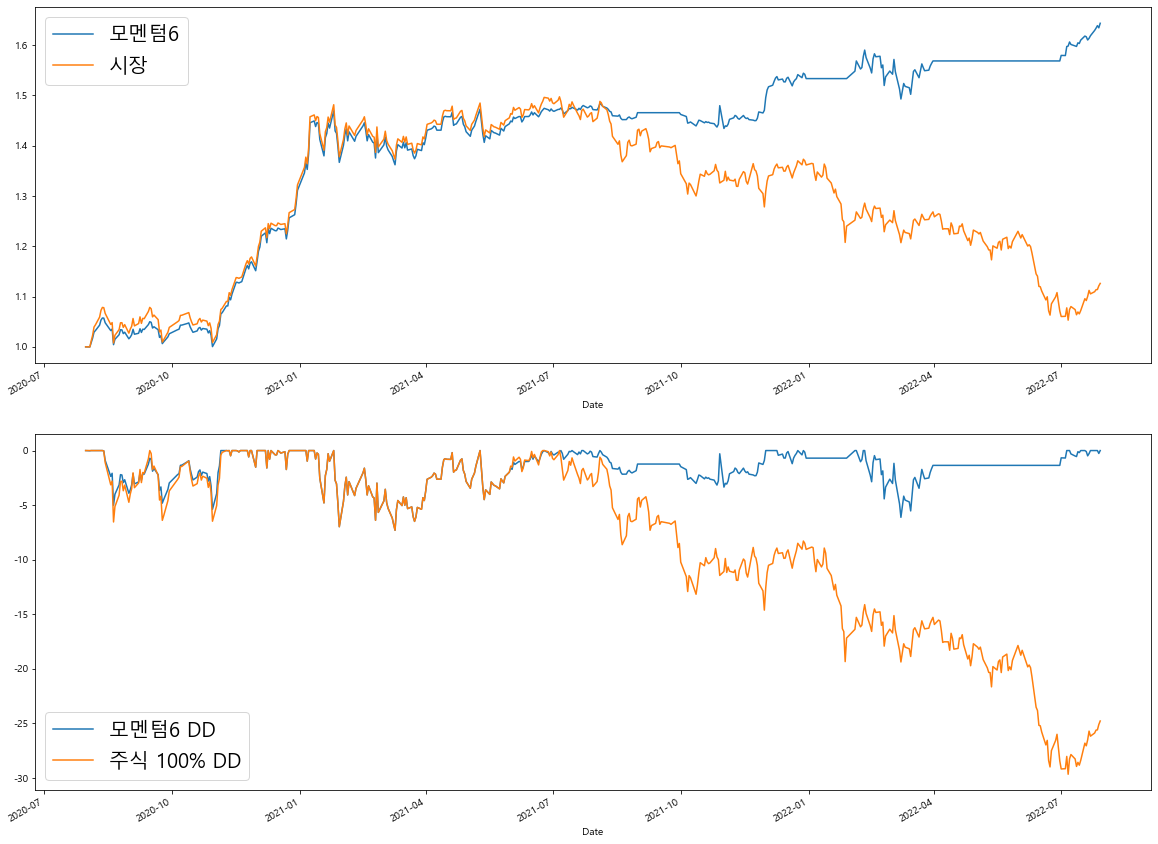

In [37]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
momentum6CumReturn.plot(label="모멘텀6")
stockCumReturn_6.plot(label="시장")
plt.legend(fontsize=20)

# dd 곡선
plt.subplot(2,1,2)
(-dd6).plot(label="모멘텀6 DD")
(-stockDD_6).plot(label="주식 100% DD")
plt.legend(fontsize=20)

plt.show()

###### 12개월 Momentum 전략

In [38]:
rebalDate_12 = getRebalancingDate(closeDataSet.loc[momentum12CumReturn.index.tolist()])

stockCumReturn_12 = getCumulativeReturn(kodex200.loc[rebalDate_12[0]:])

print(f"시장 최종수익률: {stockCumReturn_12.iloc[-1]}")
stockCagr_12, stockDD_12, stockMDD_12 = getEvaluation(stockCumReturn_12)

시장 최종수익률: 0.8172870662460567
최종 수익률: 0.8172870662460567
cagr: 0.8719285097011352
mdd: 29.655524842628516


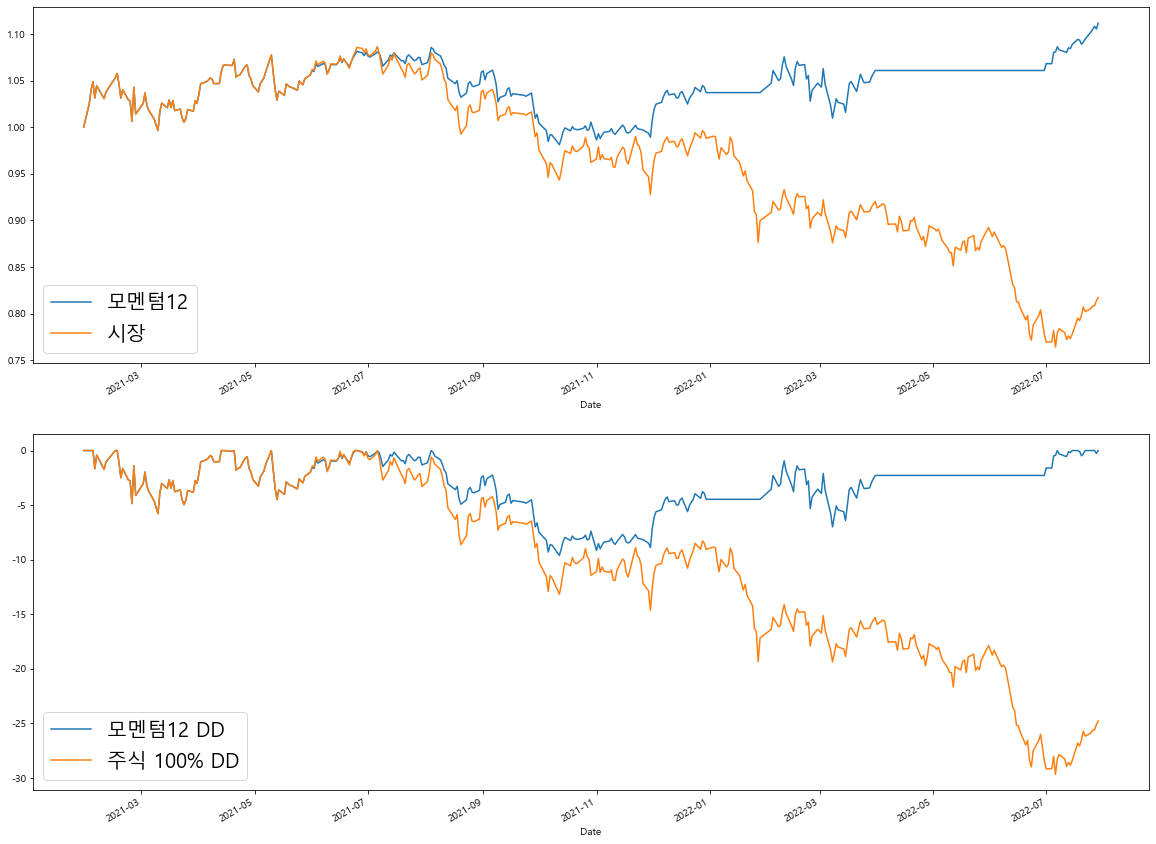

In [39]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
momentum12CumReturn.plot(label="모멘텀12")
stockCumReturn_12.plot(label="시장")
plt.legend(fontsize=20)

# dd 곡선
plt.subplot(2,1,2)
(-dd12).plot(label="모멘텀12 DD")
(-stockDD_12).plot(label="주식 100% DD")
plt.legend(fontsize=20)

plt.show()

### 과제
#### 1. 위의 누적수익률 그래프에서 잘못된 점을 찾아 이를 바로 잡는 코드를 작성하시오.
#### 2. 위의 DD 그래프에서 잘못된 점을 찾아 이를 바로 잡는 코드를 작성하시오.**